<br>
<p>
    Linux Logs Dataset is used from the following website: <a href='https://www.kaggle.com/shawon10/web-log-dataset/data'>
    Github</a>.
    <br>
    The dataset is stored in linuxlogs.txt file in <b><i>Data</i></b> dir 
    <br>
    Clean and reformatted file is store in linuxlogs.sqlite file in <b><i>Data</i></b> dir
</p>

<br>
<h4>Libraries</h4>

In [1]:
from sqlalchemy.orm import sessionmaker , relationship 
from sqlalchemy.ext.declarative import declarative_base
import sqlalchemy as db
from sqlalchemy import func ,  distinct
import geoip2.database as gdb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import requests as req
import re
from dateutil.parser import parse
import os
import calendar
sns.set_style('darkgrid')
%matplotlib inline

<br>
<h4>Storing the uncleaned data into txt file via following</h4>

<br>
<h4>Identifying the schema of the file</h4>

<p>With the help of the <a href='https://techzone.ergon.ch/syslog-message-format'>website</a>I come to conclusion that the log records has the following scehma:
    <ul>
        <li>Timestamp</li>
        <li>LogHost</li>
        <li>Application/Process</li>
        <li>Message</li>
    </ul>    
</p>

<br>
<h4> kind of meaningful information can be derived from the log file</h4>

In [2]:
def get_info():
    
    with open('./data/linuxlogs.txt',mode='r') as infile:
        log_array =  infile.readlines()                
    log_entries =  len(log_array)
    month_dic  = {}
    loghost_dic   = {}
    for logs in log_array:
        log   = logs.strip()
    #     Getting Months
        month = re.split('\s+',log)[0]
        month_dic[month] = month_dic.get(month,0) + 1
    #     Getting LogHosts
        loghost  = re.split('\s+',log)[3]
        loghost_dic[loghost] = loghost_dic.get(loghost,0) + 1

    print('\nNumber of log Entries: ',log_entries)
    print('\nMonths In Log File :' , month_dic,'\n')
    print('Loghost In Log File: ',loghost_dic,'\n')
    
get_info()


Number of log Entries:  2000

Months In Log File : {'Jun': 604, 'Jul': 1396} 

Loghost In Log File:  {'combo': 2000} 



<h4>Meaningful information that can be derived from the log file:</h4>
<ul>
    <li>There are 2000 log entries.</li>
    <li>It can be observed that this log file is covering the months of June and July.It can also be observed that the           logging activity for the month of July is more than double of that in June (in July it were 1396 whereas in June it were 604).</li>
    <li>There is also only one LogHost for this log file which is named 'combo'.</li>
    <li>After analysing the logs it can been seen it contains authentication logs, from which we would be able to access number of failed and successfull access. </li>    
    <li>We can determine authorized and unauthorized messages.</li>
    <li>The log records also contain IP address</li>    
    <li>The log records also contain Application/Process</li>
    <li>If we want to find out which user accounts have the most failed logins, we first need to extract the user name from the  correct log entries </li>    
    <li>There are also kernel logs found in the log file.These logged events can be used to observe the communication between the hardware via drivers included in the kernel or added via kernel modules and the software</li>
</ul>

<br>
<h4> log information may contribute to security control</h4>

<p>
    Log Files allows us to monitor and analyse the event logs.They act as a red flag when something bad is happening, by analysing the log files we would be able to know the company security weakeness.It allows us to recognise unauthorised logins , login failure and system failure
    <br>
    This information can provide important clues about hostile activity affecting our network from within and without.Therefore enable us to recognise our flaw and safeguard our system.
</p>

<br>
<h4>parsing method to retrieve and categorize useful information</h4>

In [3]:
def parse_logFile():
    
    with open('./data/linuxlogs.txt',mode='r') as infile:
        log_array =  infile.readlines()                

    categorised_log_records = []
    #Extract Timestamp
    extract_timeStamp           = re.compile(r'([\w\s\d\:]+)\s*combo')
    #Extract Application/Process
    extract_application_process = re.compile(r'combo\s*([\w\-\(\)\[\]\s\.]+)')
    #Extract Message
    extract_message             = re.compile(r'combo\s*[\w\-\(\)\[\]\s\.]+:(.*)')

    for logs in log_array:
        log   = logs.strip()      

        time_stamp          =  extract_timeStamp.findall(log)[0].strip()
        log_host            =  re.split('\s+',log)[3]
        application_process =  extract_application_process.search(log).groups()[0].strip()
        message             =  extract_message.search(log).groups()[0]



        categorised_log_records.append({'Timestamp':time_stamp,
                                        'LogHost':log_host,
                                        'Application/Process':application_process,
                                        'Message':message.strip()})
    return categorised_log_records

categorised_log_records = parse_logFile()

print('Peek into the Log Records After regx:\n')
print(categorised_log_records[:2])

Peek into the Log Records After regx:

[{'Timestamp': 'Jun 14 15:16:01', 'LogHost': 'combo', 'Application/Process': 'sshd(pam_unix)[19939]', 'Message': 'authentication failure; logname= uid=0 euid=0 tty=NODEVssh ruser= rhost=218.188.2.4'}, {'Timestamp': 'Jun 14 15:16:02', 'LogHost': 'combo', 'Application/Process': 'sshd(pam_unix)[19937]', 'Message': 'check pass; user unknown'}]


<br>
<h4>further categorizing the records, based on the log message in the 4th column, into <u>authorized access and unauthorized access records.</u></h4>

In [4]:
def cat_authorised():
    #get all the categorised log records
    categorised_log_records = parse_logFile()
    #contains log entires which are authorised
    authorised_records  = []
    #contains log entires which are unauthorised
    unauthorised_records= []
    for log_record in categorised_log_records:    
        message = log_record['Message']
        #we filter with fail/earning/no SOA/failure/failed keywords for unauthorised log entries
        check   = re.findall(r'(fail|warning|no SOA|failure|failed|user unknown)',message)
        if check:
            unauthorised_records.append(log_record)
        else:
            authorised_records.append(log_record)    
    return authorised_records, unauthorised_records

authorised_records, unauthorised_records = cat_authorised()

print('\nPeek Into Authorised Records :\n')
print(authorised_records[0])
print('\nPeek Into Unauthorised Records :\n')
print(unauthorised_records[0])


Peek Into Authorised Records :

{'Timestamp': 'Jun 15 04:06:18', 'LogHost': 'combo', 'Application/Process': 'su(pam_unix)[21416]', 'Message': 'session opened for user cyrus by (uid=0)'}

Peek Into Unauthorised Records :

{'Timestamp': 'Jun 14 15:16:01', 'LogHost': 'combo', 'Application/Process': 'sshd(pam_unix)[19939]', 'Message': 'authentication failure; logname= uid=0 euid=0 tty=NODEVssh ruser= rhost=218.188.2.4'}


<br>
<h4>further splitting above messages into two sub-fields: ‘access type’ (authorized or unauthorized) and ‘host/IP address’. </h4>

In [5]:
def get_accesType_hostIp():    
    
    authorised_records, unauthorised_records = cat_authorised()
    new_authorised_records   = []
    new_unauthorised_records = []
    
    #Extract only valid IPS
    extract_ip = re.compile(r'(\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b)')
    
    #Set Access Type to authorised and extract and set Ip for Authorised Log Records
    for record in authorised_records:
        record_copy = record.copy()
        record_copy['Access_Type'] = 'authorized'
        message = record['Message']
        ip      = extract_ip.findall(message)
        if ip:
            ip = ip[0]
        else:
            ip = np.nan
        record_copy['IP'] = ip
        new_authorised_records.append(record_copy)
        
    #Set Access Type to unauthorised and extract and set Ip for Unauthorised Log Records    
    for record in unauthorised_records:
        record_copy = record.copy()
        record_copy['Access_Type'] = 'unauthorized'
        message = record['Message']
        ip      = extract_ip.findall(message)
        if ip:
            ip = ip[0]
        else:
            ip = np.nan
        record_copy['IP'] = ip
        new_unauthorised_records.append(record_copy)    
    return new_authorised_records, new_unauthorised_records

new_authorised_records , new_unauthorised_records = get_accesType_hostIp()
print('Authorised_Records\n')
display(pd.DataFrame(new_authorised_records).head(2))
print('\n')
print('UnAuthorised_Records\n')
display(pd.DataFrame(new_unauthorised_records).head(2))

Authorised_Records



,Timestamp,LogHost,Application/Process,Message,Access_Type,IP
0,Jun 15 04:06:18,combo,su(pam_unix)[21416],session opened for user cyrus by (uid=0),authorized,NaN
1,Jun 15 04:06:19,combo,su(pam_unix)[21416],session closed for user cyrus,authorized,NaN




UnAuthorised_Records



,Timestamp,LogHost,Application/Process,Message,Access_Type,IP
0,Jun 14 15:16:01,combo,sshd(pam_unix)[19939],authentication failure; logname= uid=0 euid=0 ...,unauthorized,218.188.2.4
1,Jun 14 15:16:02,combo,sshd(pam_unix)[19937],check pass; user unknown,unauthorized,NaN


<br>
<h4>Storing the above parsed and cleaner data into new file</h4>

In [6]:
# file path to the current base directory 
basedir   = os.path.abspath(os.path.dirname(__name__))
file_path = os.path.join(basedir , 'data/parsedlinuxlogs.csv')

def store_parsed_csv(file_path):

    new_authorised_records , new_unauthorised_records = get_accesType_hostIp()

    df_authorised   = pd.DataFrame(new_authorised_records)
    df_unauthorised = pd.DataFrame(new_unauthorised_records)

    df = pd.concat([df_authorised,df_unauthorised])
    df = df.reset_index(drop=True)
    
    #parse it to timestamp and then sort the df
    df.Timestamp = (df.Timestamp + ' 2010').map(parse)
    df = df.sort_values(by='Timestamp').reset_index(drop=True)
    df = df.dropna().reset_index(drop=True)    
    df.to_csv(file_path,index=False)
    return df
    
df = store_parsed_csv(file_path)
df.head()

,Timestamp,LogHost,Application/Process,Message,Access_Type,IP
0,2010-06-14 15:16:01,combo,sshd(pam_unix)[19939],authentication failure; logname= uid=0 euid=0 ...,unauthorized,218.188.2.4
1,2010-06-14 15:16:02,combo,sshd(pam_unix)[19937],authentication failure; logname= uid=0 euid=0 ...,unauthorized,218.188.2.4
2,2010-06-15 12:12:34,combo,sshd(pam_unix)[23397],authentication failure; logname= uid=0 euid=0 ...,unauthorized,218.188.2.4
3,2010-06-15 12:12:34,combo,sshd(pam_unix)[23395],authentication failure; logname= uid=0 euid=0 ...,unauthorized,218.188.2.4
4,2010-06-15 12:12:34,combo,sshd(pam_unix)[23404],authentication failure; logname= uid=0 euid=0 ...,unauthorized,218.188.2.4


<br>
<h4>Creating database to store the parsed log file</h4>

In [7]:
SQLALCHEMY_DATABASE_URI = 'sqlite:///' + os.path.join(basedir,'data/linuxlogs.sqlite')
engine = db.create_engine(SQLALCHEMY_DATABASE_URI)
Base   = declarative_base(bind=engine)

# Model for Messages in Log File 
class SystemLogsMessages(Base):
    
    __tablename__ = 'SystemLogsMessages'
    
    id           = db.Column(db.Integer,primary_key=True)
    timestamp    = db.Column(db.Date)
    msg          = db.Column(db.Text)
    access_type  = db.Column(db.String(15))
    ip           = db.Column(db.String)    
    systemlog_id = db.Column(db.Integer,db.ForeignKey('SystemLogs.id'))
        
    def __repr__(self):
        return f"<Log Message> Id:{self.id}\tMessage:{self.msg}\tAccessType:{self.access_type}\tIP:{self.ip}\t"\
                + f"Timestamp:{self.timestamp}"

# Model for the entire Data in Log File
class SystemLogs(Base):    
    
    __tablename__ = 'SystemLogs'
    
    id                  = db.Column(db.Integer,primary_key=True)
    timestamp           = db.Column(db.Date)
    loghost             = db.Column(db.String)
    application_process = db.Column(db.String)
    msg                 = db.Column(db.Text)    
    detailedMessage     = relationship('SystemLogsMessages',backref='systemLog',uselist=False)
        
    def __repr__(self):
        return f"<Log Entry> Id:{self.id}\tTimeStamp:{self.timestamp}\t"\
    + f"LogHost:{self.loghost}\tApplication/Process:{self.application_process}"
    
    
Base.metadata.drop_all()
Base.metadata.create_all()

<br>
<h4>Storing the parsed cleaned log file</h4>

In [8]:
Session = sessionmaker(bind=engine)
session = Session()

def insertToDatabase():    
    
    log_instances = []    
    for i in range(len(df)):
        row = df.iloc[i]
        log_instance = SystemLogs(
            timestamp = row['Timestamp'].date(),
            loghost   = row['LogHost'],
            application_process = row['Application/Process'],
            msg = row['Message']
        )
        message_instance = SystemLogsMessages(
            timestamp = row['Timestamp'].date(),
            msg = row['Message'],
            access_type = row['Access_Type'],        
            ip  = row['IP']            
        )
        log_instance.detailedMessage =  message_instance        
        log_instances.append(log_instance)

    session.add_all(log_instances)
    session.commit()    

insertToDatabase()

<br>
<h4>Number of authorized and unauthorized access attempts on a daily basis</h4>

In [9]:
unauthorized_daily_count =session.query(SystemLogsMessages.timestamp,func.count(SystemLogsMessages.ip))\
                                 .group_by(SystemLogsMessages.timestamp)\
                                 .filter(SystemLogsMessages.access_type == 'unauthorized')\
                                 .all()
authorized_daily_count =session.query(SystemLogsMessages.timestamp,func.count(SystemLogsMessages.ip))\
                                 .group_by(SystemLogsMessages.timestamp)\
                                 .filter(SystemLogsMessages.access_type == 'authorized')\
                                 .all()
print('\n---> Below are the Authorized Acess Attempts on Daily Basis:\n')
print('Date','\t\t','Count')
for d , n in authorized_daily_count:
    print(d,'\t',n)
    
print('\n---> Below are the Unauthorized Acess Attempts on Daily Basis:\n')
print('Date','\t\t','Count')
for d , n in unauthorized_daily_count:
    print(d,'\t',n)    


---> Below are the Authorized Acess Attempts on Daily Basis:

Date 		 Count
2010-06-17 	 15
2010-06-18 	 15
2010-06-20 	 13
2010-06-22 	 23
2010-06-24 	 13
2010-06-25 	 31
2010-06-29 	 53
2010-07-01 	 23
2010-07-03 	 46
2010-07-04 	 23
2010-07-05 	 23
2010-07-06 	 23
2010-07-07 	 31
2010-07-09 	 87
2010-07-10 	 69
2010-07-15 	 22
2010-07-16 	 23
2010-07-17 	 179
2010-07-18 	 21
2010-07-21 	 23
2010-07-22 	 46
2010-07-24 	 44
2010-07-25 	 42
2010-07-26 	 23
2010-07-27 	 1

---> Below are the Unauthorized Acess Attempts on Daily Basis:

Date 		 Count
2010-06-14 	 2
2010-06-15 	 12
2010-06-17 	 1
2010-06-20 	 10
2010-06-21 	 6
2010-06-23 	 20
2010-06-28 	 14
2010-06-30 	 38
2010-07-01 	 20
2010-07-04 	 16
2010-07-05 	 5
2010-07-06 	 5
2010-07-08 	 4
2010-07-10 	 90
2010-07-11 	 20
2010-07-12 	 10
2010-07-19 	 10
2010-07-20 	 5
2010-07-21 	 6
2010-07-23 	 11
2010-07-24 	 5
2010-07-26 	 23


<br>
<h4>Does any <u>authorized</u> IP address occur repeatedly? If it does, list out the duplicated IP addresses.</h4>

In [10]:
subquery = session.query(SystemLogsMessages.ip)\
                  .group_by(SystemLogsMessages.ip)\
                  .filter(SystemLogsMessages.access_type == 'authorized')\
                  .having(func.count(SystemLogsMessages.ip)>1).subquery()
duplicated_auth_ips  = session.query(distinct(SystemLogsMessages.ip))\
                              .filter(SystemLogsMessages.ip.in_(subquery)).all()
print('\nListing Duplicated IP addresses for authorized access:\n')
for ip in duplicated_auth_ips:
    print(ip[0])


Listing Duplicated IP addresses for authorized access:

24.54.76.216
82.252.162.81
222.33.90.199
210.245.165.136
218.69.108.57
210.118.170.95
211.167.68.59
61.74.96.178
208.62.55.75
210.223.97.117
202.82.200.188
203.101.45.59
62.99.164.82
63.197.98.106
211.72.2.106
211.72.151.162
221.4.102.93
211.57.88.250
81.171.220.226
206.196.21.129
217.187.83.139
82.83.227.67
220.94.205.45
211.107.232.1
212.65.68.82
83.116.207.11
218.146.61.230
207.30.238.8
82.68.222.194
82.68.222.195
216.12.111.241
211.42.188.206
67.95.49.172
84.102.20.2
206.47.209.10
217.187.83.50
172.181.208.156


<br>
<h4>Does any <u>unauthorized</u> IP address occur repeatedly ? If it does, listing out the duplicated IP addresses.</h4>

In [11]:
subquery = session.query(SystemLogsMessages.ip)\
                      .group_by(SystemLogsMessages.ip)\
                      .filter(SystemLogsMessages.access_type == 'unauthorized')\
                      .having(func.count(SystemLogsMessages.ip)>1).subquery()
duplicated_unauth_ips  = session.query(distinct(SystemLogsMessages.ip))\
                                .filter(SystemLogsMessages.ip.in_(subquery)).all()
print('\nListing Duplicated IP addresses for unauthorized access:\n')
for ip in duplicated_unauth_ips:
    print(ip[0])    


Listing Duplicated IP addresses for unauthorized access:

218.188.2.4
65.166.159.14
217.60.212.66
209.152.168.249
218.22.3.51
61.53.154.93
211.115.206.155
60.30.224.116
195.129.24.210
163.27.187.39
210.76.59.29
220.117.241.87
210.229.150.228
218.16.122.48
212.0.132.20
150.183.249.110
211.214.161.141
82.77.200.128
211.137.205.253
68.143.156.89
202.181.236.180
218.55.234.102
193.110.106.11
211.9.58.217
203.251.225.101
207.243.167.114


<br>
<h4>Loading the parsed log file to Pandas and using it to derive the above same queries</h4>

In [12]:
# getting data from the database SystemLogsMessages
log_msg_df = pd.read_sql('SystemLogsMessages',engine,index_col='id')\
                .rename(lambda x : x.upper(),axis=1)

def loading_queries_pd(df):    
    
    # i
    daily_counts = df.set_index("TIMESTAMP")\
                     .resample('D')['ACCESS_TYPE'].apply(lambda col : col.value_counts())\
                     .unstack().fillna(0)
    # ii

    authorized_duplicated_ip = df[df.ACCESS_TYPE == 'authorized']
    authorized_duplicated_ip = authorized_duplicated_ip[authorized_duplicated_ip.IP.duplicated(keep=False)]\
                               .IP.unique()
    authorized_duplicated_ip = pd.DataFrame(authorized_duplicated_ip)\
                                 .rename({0:'Duplicated Authorized IP addresses'},axis=1)
    # iii
    unauthorized_duplicated_ip = df[df.ACCESS_TYPE == 'unauthorized']
    unauthorized_duplicated_ip = unauthorized_duplicated_ip[unauthorized_duplicated_ip.IP.duplicated(keep=False)]\
                                .IP.unique()
    unauthorized_duplicated_ip = pd.DataFrame(unauthorized_duplicated_ip)\
                                   .rename({0:'Duplicated Unauthorized IP addresses'},axis=1)
    
    print('\n---> Number of authorized and unauthorized access attempts on a daily basis\n')
    display(daily_counts)
    
    print('\n')
    
    print('---> Duplicated Authorized IP addresses\n')
    display(authorized_duplicated_ip)

    print('\n')
    
    print('---> Duplicated Unauthorized IP addresses\n')
    display(unauthorized_duplicated_ip)    

loading_queries_pd(log_msg_df)


---> Number of authorized and unauthorized access attempts on a daily basis



,authorized,unauthorized
TIMESTAMP,,
2010-06-14,0.0,2.0
2010-06-15,0.0,12.0
2010-06-17,15.0,1.0
2010-06-18,15.0,0.0
2010-06-20,13.0,10.0
2010-06-21,0.0,6.0
2010-06-22,23.0,0.0
2010-06-23,0.0,20.0
2010-06-24,13.0,0.0




---> Duplicated Authorized IP addresses



,Duplicated Authorized IP addresses
0,24.54.76.216
1,82.252.162.81
2,222.33.90.199
3,210.245.165.136
4,218.69.108.57
5,210.118.170.95
6,211.167.68.59
7,61.74.96.178
8,208.62.55.75
9,210.223.97.117




---> Duplicated Unauthorized IP addresses



,Duplicated Unauthorized IP addresses
0,218.188.2.4
1,65.166.159.14
2,217.60.212.66
3,209.152.168.249
4,218.22.3.51
5,61.53.154.93
6,211.115.206.155
7,60.30.224.116
8,195.129.24.210
9,163.27.187.39


<br>
<h4>Discover the peak days that unauthorized accesses happen.</h4>

In [13]:
#function to compute the days in a week (i.e. Mon, Tue or Wed) for any given date.
def get_day(date):
    
    day = date.dayofweek
    return  calendar.day_abbr[day]

<br>
<h4>Updating the days in a week</h4>

In [14]:
def update_daysinaweek(log_msg_df):
    
    #DayInAWeek column created on basis of TIMESTAMP col
    log_msg_df['DayInAWeek'] = log_msg_df['TIMESTAMP'].map(get_day)
    return log_msg_df

log_msg_df = update_daysinaweek(log_msg_df)
display(log_msg_df.head(3))

,TIMESTAMP,MSG,ACCESS_TYPE,IP,SYSTEMLOG_ID,DayInAWeek
id,,,,,,
1,2010-06-14,authentication failure; logname= uid=0 euid=0 ...,unauthorized,218.188.2.4,1,Mon
2,2010-06-14,authentication failure; logname= uid=0 euid=0 ...,unauthorized,218.188.2.4,2,Mon
3,2010-06-15,authentication failure; logname= uid=0 euid=0 ...,unauthorized,218.188.2.4,3,Tue


<br>
<h4>Listing out the top THREE (3) days in a week that unauthorized access occurred.</h4>

In [15]:
def get_top_3_days(log_msg_df):
    
    top_3_day_unauthorized = log_msg_df[log_msg_df['ACCESS_TYPE'] == 'unauthorized']['DayInAWeek']\
                                        .value_counts().head(3)\
                                        .to_frame(name='Top 3 Days')
    return top_3_day_unauthorized

top_3_day_unauthorized = get_top_3_days(log_msg_df)
print('\nTOP 3 Days In A Week For Unauthorized Access:\n')
display(top_3_day_unauthorized)


TOP 3 Days In A Week For Unauthorized Access:



,Top 3 Days
Sat,95
Mon,70
Wed,64


<br>
<h4>Visualizing the variation of unauthorized access between June and July</h4>

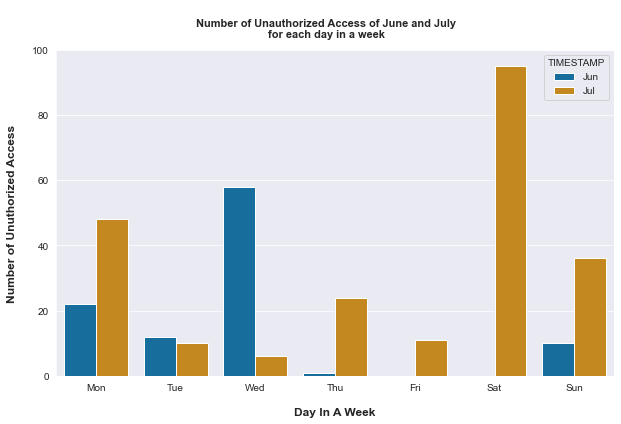

In [16]:
def visualize(log_msg_df):
    
    """
    Visualize the variation of unauthorized access between June and July
    """
    
    unauth_log_ms_df = log_msg_df[log_msg_df['ACCESS_TYPE']=='unauthorized'].reset_index(drop=True)
    month_ser        =  unauth_log_ms_df['TIMESTAMP'].dt.month.map(lambda x : calendar.month_abbr[x])

    fig , axes= plt.subplots(1,1,figsize=(10,6))
    sns.set_style('darkgrid')
    sns.countplot(unauth_log_ms_df['DayInAWeek'],hue=month_ser,ax=axes,
                  order=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],
                  palette='colorblind',hue_order=['Jun','Jul'])
    axes.set(ylim=(0,100))
    axes.xaxis.labelpad = 15
    axes.yaxis.labelpad = 15
    axes.set_ylabel('Number of Unuthorized Access',fontweight=600,fontsize=12)
    axes.set_xlabel('Day In A Week',fontweight=600,fontsize=12)
    fig.suptitle('\nNumber of Unauthorized Access of June and July\nfor each day in a week',fontsize=11,fontweight=600)
    plt.show()
    
visualize(log_msg_df)

<br>
<h4>function to extract the country name and city name for a given IP address</h4>

In [17]:
mmdbfilepath = os.path.join(basedir,'data/GeoLite2-City.mmdb')

city = gdb.Reader(mmdbfilepath)
def extract_country_city(ip,city):
    
    """
    function to extract the country name and city name for a given IP address
    """
    
    cityname    = city.city(ip).city.name
    if not cityname:
        cityname = np.nan    
    countryname = city.city(ip).country.name
    if not countryname:
        countryname = np.nan    
    return [countryname,cityname]

<br>
<h4>Updating the country and city into the column/field of the Dataframe</h4>

In [18]:
def update_country_city(df,city):
    
    temp_df = pd.DataFrame(df['IP'].map(lambda ip : extract_country_city(ip,city))\
                           .to_list(),columns=['Country','City'])
    
    df      = pd.concat([df.reset_index(drop=True), temp_df],axis=1)
    df.index.name = 'id'
    
    return df

new_log_msg_df = update_country_city(log_msg_df,city)
display(new_log_msg_df.head(3))

,TIMESTAMP,MSG,ACCESS_TYPE,IP,SYSTEMLOG_ID,DayInAWeek,Country,City
id,,,,,,,,
0,2010-06-14,authentication failure; logname= uid=0 euid=0 ...,unauthorized,218.188.2.4,1,Mon,Hong Kong,NaN
1,2010-06-14,authentication failure; logname= uid=0 euid=0 ...,unauthorized,218.188.2.4,2,Mon,Hong Kong,NaN
2,2010-06-15,authentication failure; logname= uid=0 euid=0 ...,unauthorized,218.188.2.4,3,Tue,Hong Kong,NaN


<br>
<h4>Listing out the top THREE (3) countries where the unauthorized access originated from</h4>

In [19]:
def top_3_countries(df):
    
    df = df[df['ACCESS_TYPE'] == 'unauthorized']['Country']\
            .value_counts().head(3).to_frame()
    return df

top_3_country = top_3_countries(new_log_msg_df)
print('\nTop THREE (3) countries for unauthorized access:\n')
display(top_3_country)


Top THREE (3) countries for unauthorized access:



,Country
South Korea,119
China,60
United States,53


<br>
<h4>Visualize the authorized and unauthorized access for each country</h4>

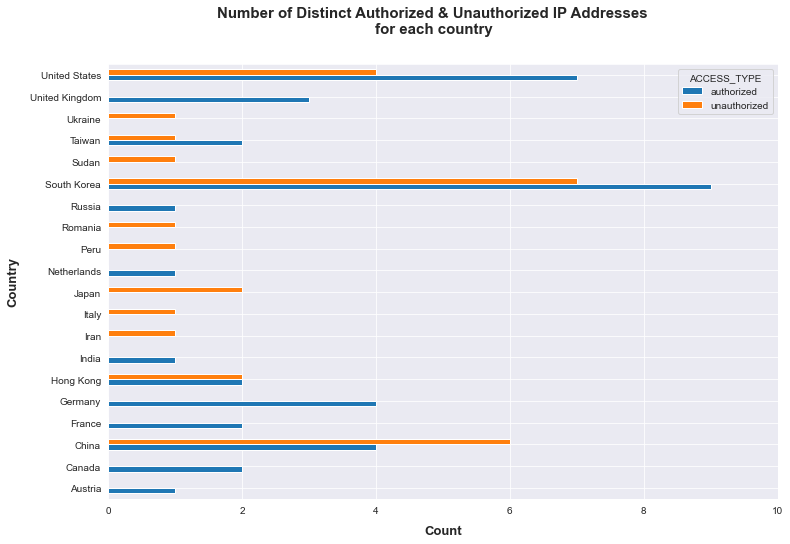

In [20]:
def visualize_country(df):
    
    """
    Visualize the authorized and unauthorized access for each country
    
    """
    
#     Gets me all the rows where country is not na
    temp_df = df[df['Country'].notna()]
#     Gets me the grouped frame which contains number of unique ip addressess for each country 
#     by ACCESS_TYPE
    df_plot = temp_df.groupby('Country')\
                     .apply(lambda df : df.groupby('ACCESS_TYPE')['IP'].nunique())\
                     .unstack().fillna(0)
#     Plotting
    sns.set_style('darkgrid')
    fig , axes = plt.subplots(1,1,figsize=(12,8))
    df_plot.plot.barh(ax = axes)
    axes.set_xlabel('Count',fontweight=600,fontsize=13)
    axes.set_ylabel('Country',fontweight=600,fontsize=13)
    axes.xaxis.labelpad = 10
    axes.yaxis.labelpad = 10
    axes.set(xlim=(0,10))
    fig.suptitle('Number of Distinct Authorized & Unauthorized IP Addresses\n for each country',fontweight=600,fontsize=15)
    plt.show()

print('\n\n')
visualize_country(new_log_msg_df)